# Routed sequencing

This demo uses the basal ganglia model to cycle through a 5 element sequence, where an
arbitrary start can be presented to the model. The addition of routing allows the system
to choose between two different actions: whether to go through the sequence, or be
driven by the visual input. If the visual input has its value set to 0.8*START+D (for
instance), it will begin cycling through at D$\rightarrow$E, etc. The 0.8 scaling helps
ensure start is unlikely to accidentally match other SPAs (which can be a problem in low
dimensional examples like this one).

In [1]:
%matplotlib inline

import nengo
import matplotlib.pyplot as plt

import nengo_spa as spa

seed = 0

## Step 1: Create the model

Notice that when you specify actions, you're determining which modules are connected to
which. For example, by having a mapping that depends on the state of cortex, you are
determining that the cortex and basal ganglia must be connected. As well, when you
specify that the result of the action changes the state of cortex, then you are
determining that thalamus must be connected to cortex.

In [2]:
def start(t):
    if t < 0.1:
        return "0.8*START+D"
    else:
        return "0"


# Number of dimensions for the Semantic Pointers
dimensions = 16

# Make a model object with the SPA network
model = spa.Network(label="Routed_Sequence", seed=seed)

with model:
    # Specify the modules to be used
    vision = spa.Transcode(start, output_vocab=dimensions)
    cortex = spa.State(dimensions)

    # Specify the action mapping
    with spa.ActionSelection() as action_sel:
        spa.ifmax("Start", spa.dot(vision, spa.sym.START), vision >> cortex)
        spa.ifmax("A to B", spa.dot(cortex, spa.sym.A), spa.sym.B >> cortex)
        spa.ifmax("B to C", spa.dot(cortex, spa.sym.B), spa.sym.C >> cortex)
        spa.ifmax("C to D", spa.dot(cortex, spa.sym.C), spa.sym.D >> cortex)
        spa.ifmax("D to E", spa.dot(cortex, spa.sym.D), spa.sym.E >> cortex)
        spa.ifmax("E to A", spa.dot(cortex, spa.sym.E), spa.sym.A >> cortex)

## Step 3: Probe the output

In [3]:
with model:
    p_cortex = nengo.Probe(cortex.output, synapse=0.01)
    p_vision = nengo.Probe(vision.output, synapse=0.01)
    p_selected_actions = nengo.Probe(action_sel.thalamus.output, synapse=0.01)
    p_utility = nengo.Probe(action_sel.bg.input, synapse=0.01)

## Step 4: Run the model

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

## Step 5: Plot the results

Text(0.5, 0, 'Time (s)')

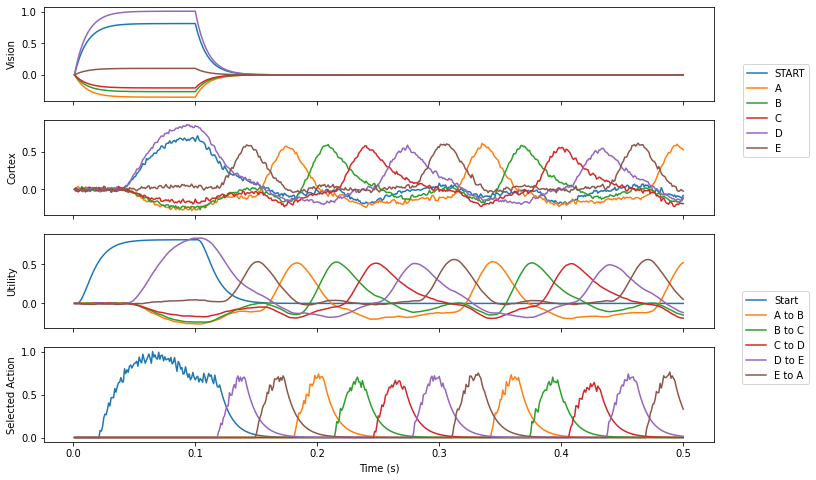

In [5]:
vocab = model.vocabs[dimensions]

fig, (p1, p2, p3, p4) = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
p1.plot(sim.trange(), spa.similarity(sim.data[p_vision], vocab))
p1.legend(vocab.keys(), loc="right", bbox_to_anchor=(1.15, -0.1))
p1.set_ylabel("Vision")

p2.plot(sim.trange(), spa.similarity(sim.data[p_cortex], vocab))
p2.set_ylabel("Cortex")

p3.plot(sim.trange(), sim.data[p_utility])
p3.legend(tuple(action_sel.keys()), loc="right", bbox_to_anchor=(1.15, -0.1))
p3.set_ylabel("Utility")

p4.plot(sim.trange(), sim.data[p_selected_actions])
p4.set_ylabel("Selected Action")
p4.set_xlabel("Time (s)")